# Get data

In [67]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [68]:
names = open("names.txt").read().splitlines()
context = 8

ds = []
for name in names:
    n = '.'*context + name + '.'
    tuples = list(zip(*list(n[i:] for i in range(context + 1))))
    ds.extend(list(map(lambda tup: (tup[0:context], tup[context]), tuples)))

ds[:15]

[(('.', '.', '.', '.', '.', '.', '.', '.'), 'e'),
 (('.', '.', '.', '.', '.', '.', '.', 'e'), 'm'),
 (('.', '.', '.', '.', '.', '.', 'e', 'm'), 'm'),
 (('.', '.', '.', '.', '.', 'e', 'm', 'm'), 'a'),
 (('.', '.', '.', '.', 'e', 'm', 'm', 'a'), '.'),
 (('.', '.', '.', '.', '.', '.', '.', '.'), 'o'),
 (('.', '.', '.', '.', '.', '.', '.', 'o'), 'l'),
 (('.', '.', '.', '.', '.', '.', 'o', 'l'), 'i'),
 (('.', '.', '.', '.', '.', 'o', 'l', 'i'), 'v'),
 (('.', '.', '.', '.', 'o', 'l', 'i', 'v'), 'i'),
 (('.', '.', '.', 'o', 'l', 'i', 'v', 'i'), 'a'),
 (('.', '.', 'o', 'l', 'i', 'v', 'i', 'a'), '.'),
 (('.', '.', '.', '.', '.', '.', '.', '.'), 'a'),
 (('.', '.', '.', '.', '.', '.', '.', 'a'), 'v'),
 (('.', '.', '.', '.', '.', '.', 'a', 'v'), 'a')]

In [69]:
vocab = sorted(set('.'.join(names)))
ctoi = {c: i for i, c in enumerate(vocab)}
itoc = {i: c for c, i in ctoi.items() }

In [70]:
import torch.nn.functional as F

In [71]:
ids = torch.zeros(len(ds), context + 1, dtype=torch.int)
for i, (x, y) in enumerate(ds):
    ids[i, 0:context] = torch.tensor(list(map(lambda c: ctoi[c],x)))
    ids[i, context] = ctoi[y]

ods = F.one_hot(ids.long(), 27)
ods.shape


torch.Size([228146, 9, 27])

In [286]:
class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.w = torch.randn(n_in, n_out) / (n_in ** 0.5)
        self.b = torch.zeros(n_out) if bias else None
        self.training = True

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])
    
    def train(self, value=True):
        self.training = value
    
class BatchNorm1d:
    def __init__(self, n, momentum=0.001, eps=1e-5):
        self.gain = torch.ones(n)
        self.bias = torch.zeros(n)
        self.r_var = torch.ones(n)
        self.r_mean = torch.zeros(n)
        self.momentum = momentum
        self.eps = eps
        self.training = True

    def __call__(self, x):
        dims = 0 if x.ndim == 2 else (0, 1)
        mean = x.mean(dims, keepdims=True) if self.training else self.r_mean
        var = x.std(dims, keepdims=True) if self.training else self.r_var
        
        self.out = self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias

        if self.training:
            with torch.no_grad():
                self.r_var = (1 - self.momentum) * self.r_var + self.momentum * var
                self.r_mean = (1 - self.momentum) * self.r_mean + self.momentum * mean
        
        return self.out

    def parameters(self):
        return [self.gain, self.bias]
    
    def train(self, value=True):
        self.training = value
        
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []
    
    def train(self, value=True): pass
    
class Embedding:
    def __init__(self, vocab_size, dim):
        self.C = torch.randn(vocab_size, dim)
        self.training = True
    
    def __call__(self, xb):
        self.out = self.C[xb]
        return self.out

    def parameters(self):
        return [self.C]
    
    def train(self, value=True):
        self.training = value

    
class Flatten:
    def __init__(self, *dims):
        self.dims = dims

    def __call__(self, xb):
        self.out = xb
        if self.out.ndim == 2: self.out = self.out.unsqueeze(0)

        bs = self.out.shape[0]
        self.out = self.out.view(bs, *(self.dims if len(self.dims) else (-1,)))
        return self.out
    
    def parameters(self):
        return []
    
    def train(self, value=True): pass
    
class Sequential:
    def __init__(self, *layers):
        self.layers = layers
        self.training = True

    def __call__(self, xb):
        self.out = xb
        for layer in self.layers:
            self.out = layer(self.out)
        return self.out
        
    def parameters(self):
        return [params for layer in self.layers for params in layer.parameters()]
    
    def train(self, value=True):
        for layer in self.layers: layer.train(value)
        self.training = value

In [287]:
n1 = int(0.8*len(ids))
n2 = int(0.9*len(ids))

shuffled = ids[torch.randint(0, len(ids), (len(ids),))]

tr = shuffled[0:n1]
val = shuffled[n1:n2]
test = shuffled[n2:]

tr.shape, val.shape, test.shape


(torch.Size([182516, 9]), torch.Size([22815, 9]), torch.Size([22815, 9]))

In [288]:
def getxy(ds):
    return ds[:, :context], F.one_hot(ds[:, -1].long(), len(vocab)).float()

Xtr, Ytr = getxy(tr)
Xval, Yval = getxy(val)
Xtest, Ytest = getxy(test)
Xval.shape, Yval.shape

(torch.Size([22815, 8]), torch.Size([22815, 27]))

# Initialization

In [295]:
from functools import reduce
import ramda as R


n_emb = 24
n_hidden = 128

layers = [
    Embedding(len(vocab), n_emb),
    Flatten(4, 2*n_emb),    Linear(2*n_emb   , n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Flatten(2, 2*n_hidden), Linear(2*n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Flatten(),              Linear(2*n_hidden, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
                            Linear(n_hidden,   len(vocab)),
]
model = Sequential(*layers)

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear): layer.w *= 5/3

for param in model.parameters(): param.requires_grad_()

reduce(lambda acc, cur: R.add(acc, cur.numel()), model.parameters(), 0)

76963

# Training

In [296]:
tr_loss = []
val_loss = []

In [304]:
itr = 50000
bs  = 32*4
rfq = 1000
ud = []

for i in range(itr):
    lr = 0.05 if i < 20000 else 0.005

    bi = torch.randint(0, len(Xtr), (bs,))
    xb, yb = Xtr[bi], Ytr[bi]

    # Forward
    model.train()
    x = model(xb)

    # Loss
    loss = F.cross_entropy(x, yb)

    # Optim
    for layer in layers: layer.out.retain_grad()
    for p in model.parameters(): p.grad = None
    loss.backward()
    for p in model.parameters(): p.data  -= p.grad * lr

    # Report
    if i % rfq == 0:
        tr_loss.append(loss.item())
        
        model.train(False)
        preds = model(Xval)
        val_loss.append(F.cross_entropy(preds, Yval).item())

        print(f"{i}: Tr {loss:.2f} | Val {val_loss[-1]:.2f}")

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])


    # if i == 10000: break;

0: Tr 1.72 | Val 1.93
1000: Tr 1.86 | Val 1.97
2000: Tr 1.69 | Val 1.97
3000: Tr 1.73 | Val 1.97
4000: Tr 1.85 | Val 1.97
5000: Tr 1.67 | Val 1.97
6000: Tr 1.91 | Val 1.96
7000: Tr 1.76 | Val 1.96
8000: Tr 1.90 | Val 1.97
9000: Tr 1.96 | Val 1.96
10000: Tr 1.68 | Val 1.96
11000: Tr 1.78 | Val 1.95
12000: Tr 1.54 | Val 1.95
13000: Tr 1.94 | Val 1.95
14000: Tr 1.65 | Val 1.95
15000: Tr 1.61 | Val 1.96
16000: Tr 1.70 | Val 1.96
17000: Tr 1.50 | Val 1.95
18000: Tr 1.59 | Val 1.95
19000: Tr 1.48 | Val 1.95
20000: Tr 1.77 | Val 1.95
21000: Tr 1.56 | Val 1.91
22000: Tr 1.53 | Val 1.91
23000: Tr 1.80 | Val 1.90
24000: Tr 1.64 | Val 1.90
25000: Tr 1.56 | Val 1.90
26000: Tr 1.84 | Val 1.90
27000: Tr 1.83 | Val 1.90
28000: Tr 1.82 | Val 1.90
29000: Tr 1.61 | Val 1.90
30000: Tr 1.76 | Val 1.90
31000: Tr 1.62 | Val 1.90
32000: Tr 1.80 | Val 1.90
33000: Tr 1.66 | Val 1.90
34000: Tr 1.73 | Val 1.90
35000: Tr 1.68 | Val 1.90
36000: Tr 1.65 | Val 1.90
37000: Tr 1.66 | Val 1.90
38000: Tr 1.47 | Val 1.90

In [302]:
for layer in model.layers:
    print(f'{layer.__class__.__name__:12s}: {layer.out.shape}')

Embedding   : torch.Size([128, 8, 24])
Flatten     : torch.Size([128, 4, 48])
Linear      : torch.Size([128, 4, 128])
BatchNorm1d : torch.Size([128, 4, 128])
Tanh        : torch.Size([128, 4, 128])
Flatten     : torch.Size([128, 2, 256])
Linear      : torch.Size([128, 2, 128])
BatchNorm1d : torch.Size([128, 2, 128])
Tanh        : torch.Size([128, 2, 128])
Flatten     : torch.Size([128, 256])
Linear      : torch.Size([128, 128])
BatchNorm1d : torch.Size([128, 128])
Tanh        : torch.Size([128, 128])
Linear      : torch.Size([128, 27])


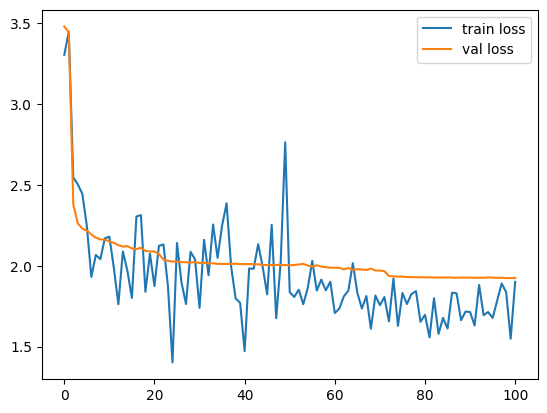

In [303]:
x = torch.arange(0, len(tr_loss))

l1, l2 = plt.plot(x, tr_loss, x, val_loss);

l1.set_label("train loss")
l2.set_label("val loss")
plt.legend();

In [265]:
model.train(False)
f"test loss: {F.cross_entropy(model(Xtest), Ytest):.2f}"

'test loss: 2.13'

# Name gen

In [266]:
gen = []
model.train(False)

for i in range(20):
    res = []
    input = torch.tensor(list(map(int, context*'0')))

    while True:
        z = model(input)
        predi = torch.multinomial(F.softmax(z, dim=1), 1).squeeze()
        predc = itoc[predi.item()]

        if predc == '.': break

        res.append(predc)
        input = torch.concat([input[1:], predi[None]])

    gen.append(''.join(res))

gen

['neender',
 'kuslon',
 'keelithelo',
 'tashn',
 'cemany',
 'jandrian',
 'hukmil',
 'beakinklon',
 'mayon',
 'iplan',
 'zaek',
 'hileiell',
 'ryleid',
 'jeronne',
 'picsara',
 'khomyb',
 'brayten',
 'siuniyah',
 'marciel',
 'cellond']